In [1]:
from pathlib import Path
from typing import Any

import numpy as np
import torch

from src.geometry.point_transformation import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.splats.splats_utils import *
import itertools

In [2]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Initializing covariances for Gaussian Splats 

In the paper they initialize covariances as isotropic with axes equal to the distance to the 3 nearest neighbours. But for now I initialized it from uniform distribution



In [3]:
diagonal = np.array([[1.0, 0, 0], [0, 1.0, 0], [0, 0, 1.0]])

def init_from_uniform(n):
    covs = np.zeros((n, 3, 3), dtype=np.float32)
    vals = np.random.uniform(low=0.1, high=0.3, size=n)
    covs[:, 0, 0] = vals
    covs[:, 1, 1] = vals
    covs[:, 2, 2] = vals
    return covs

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
requires_grad = True

In [6]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'
output_path = scene_folder / 'undistorted_images'

pcd = o3d.io.read_point_cloud(str(scene_folder / 'sparse.ply'))
# pcd.compute_mean_and_covariance()
# pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=3)) 
points = torch.tensor(np.asarray(pcd.points), device=device, requires_grad=requires_grad, dtype=torch.float32)
colors = torch.tensor(np.asarray(pcd.colors), device=device, requires_grad=requires_grad, dtype=torch.float32)
covariances = torch.tensor(init_from_uniform(len(points)), device=device, dtype=torch.float32) # np.asarray(pcd.covariances)

In [7]:
covariances[0]

tensor([[0.1831, 0.0000, 0.0000],
        [0.0000, 0.1831, 0.0000],
        [0.0000, 0.0000, 0.1831]], device='cuda:0')

In [8]:
def convert_to_homogenous(points: torch.Tensor):
    return torch.concatenate((points, torch.ones((len(points), 1), dtype=torch.float32, device=device)), dim=1)

def to_ndc_coordinates(clip_coordinates):
    '''
    Converts to Normalized Device Coordinates
    :param clip_coordinates:
    :return:
    '''
    ndc_coordinates = clip_coordinates[:, :3] / clip_coordinates[:, 3:]
    return ndc_coordinates


def to_screen_coordinates(ndc_coordinates, width, height, zfar, znear):
    x_off, y_off = 0, 0

    screen_coordinates = torch.zeros_like(ndc_coordinates)

    screen_coordinates[:, 0] = x_off + 0.5 * (-ndc_coordinates[:, 0] + 1) * width
    screen_coordinates[:, 1] = y_off + 0.5 * (-ndc_coordinates[:, 1] + 1) * height
    screen_coordinates[:, 2] = 0.5 * (zfar - znear) * ndc_coordinates[:, 2] + 0.5 * (zfar + znear)  # can be used to resolve depth
    return screen_coordinates


In [9]:
reconstruction = pycolmap.Reconstruction(output_path / 'sparse')

img_id = 1
img = reconstruction.images[img_id]
cam_id = 1

extrinsic_matrix = get_extrinsic_params(img.cam_from_world)
f, cx, cy = reconstruction.cameras[cam_id].params
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 5
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear)
W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation

extrinsic_matrix_pt = torch.tensor(extrinsic_matrix, device=device, dtype=torch.float32)
intrinsic_matrix_pt = torch.tensor(intrinsic_matrix, device=device, dtype=torch.float32)

homogeneous_points = convert_to_homogenous(points)
camera_coordinates = homogeneous_points @ extrinsic_matrix_pt.T
clip_coordinates = camera_coordinates @ intrinsic_matrix_pt.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)

ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
c = colors[point_ids]

screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
cov_3d = covariances[point_ids]

In [10]:
f_pt = torch.scalar_tensor(f, device=device, dtype=torch.float32)

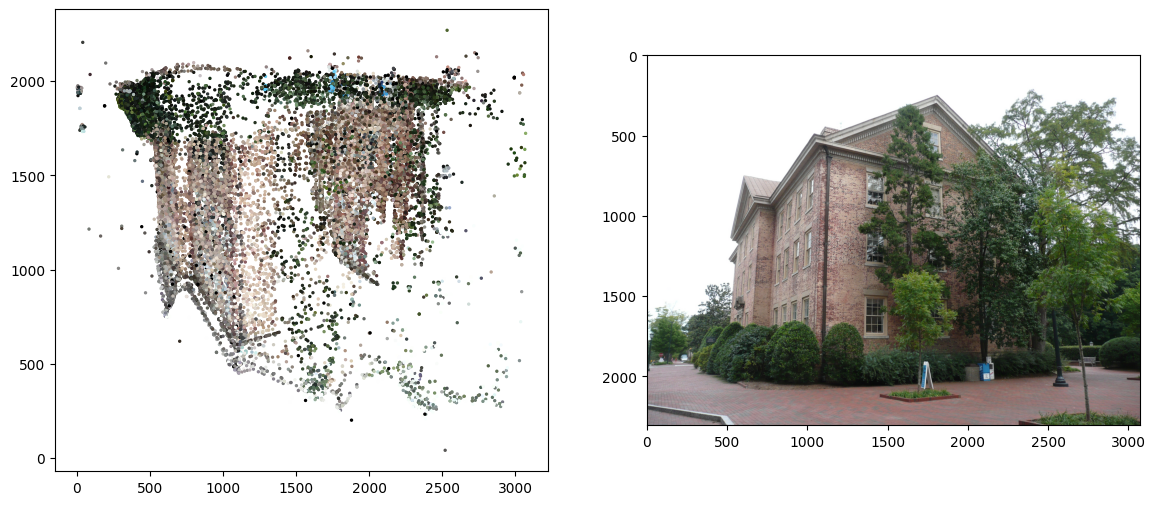

In [11]:
screen_coordinates_np = screen_coordinates.clone().detach().to('cpu')
image = mpimg.imread(images_folder / f'{img.name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates_np[:, 0], screen_coordinates_np[:, 1], s=2, c=c.clone().detach().to('cpu'))
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

In [12]:
print(f"# filtered points {sum(point_ids)}")
print(f"# total points {reconstruction.num_points3D()}")

# filtered points 33008
# total points 57713


In [13]:
n = sum(point_ids)

This is how our ground truth looks like - it is an image from a given camera 

In [14]:
print("Image shape: ", image.shape)
print(image[500, 500])

Image shape:  (2304, 3072, 3)
[255 255 255]


#### Initialization

We will optimize the attributes of Gaussians:
- coordinates $[x, y, z]$ (initialized from SFM)
- color (in original paper they use SH, but I think that RGB color is simpler as for now)
- alpha = opacity
- covariance matrix

we'll use pytorch to train these parameters (even though we don't have a model)

In [15]:
alphas_exponents_pt = torch.rand(n, requires_grad=requires_grad, device=device, dtype=torch.float32) * 6 - 3 

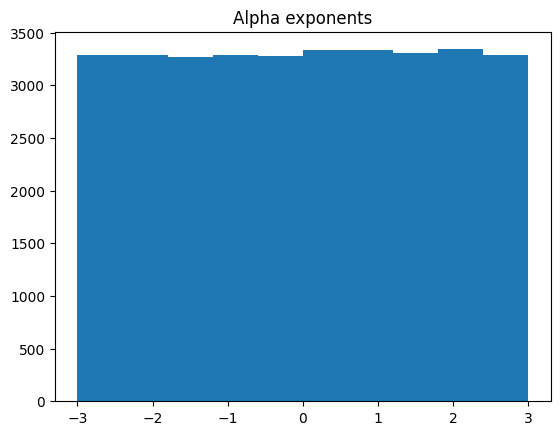

In [16]:
plt.hist(alphas_exponents_pt.detach().cpu())
_ = plt.title('Alpha exponents')

We'll use initialized covariances to set up values for scale exponents and rotation matrices

In [17]:
cov_3d

tensor([[[0.1831, 0.0000, 0.0000],
         [0.0000, 0.1831, 0.0000],
         [0.0000, 0.0000, 0.1831]],

        [[0.2088, 0.0000, 0.0000],
         [0.0000, 0.2088, 0.0000],
         [0.0000, 0.0000, 0.2088]],

        [[0.1033, 0.0000, 0.0000],
         [0.0000, 0.1033, 0.0000],
         [0.0000, 0.0000, 0.1033]],

        ...,

        [[0.1553, 0.0000, 0.0000],
         [0.0000, 0.1553, 0.0000],
         [0.0000, 0.0000, 0.1553]],

        [[0.1252, 0.0000, 0.0000],
         [0.0000, 0.1252, 0.0000],
         [0.0000, 0.0000, 0.1252]],

        [[0.1363, 0.0000, 0.0000],
         [0.0000, 0.1363, 0.0000],
         [0.0000, 0.0000, 0.1363]]], device='cuda:0')

In [18]:
eigenvalues, eigenvectors = torch.linalg.eig(cov_3d)

In [19]:
eigenvalues.real

tensor([[0.1831, 0.1831, 0.1831],
        [0.2088, 0.2088, 0.2088],
        [0.1033, 0.1033, 0.1033],
        ...,
        [0.1553, 0.1553, 0.1553],
        [0.1252, 0.1252, 0.1252],
        [0.1363, 0.1363, 0.1363]], device='cuda:0')

In [20]:
lower = 1e-20 # add some small value to prevent 0 as log argument

rot = eigenvectors.real.requires_grad_(requires_grad)

# Similarly to alphas we'll actually optimize exponents
scale = torch.sqrt(torch.abs(eigenvalues.real[:, np.newaxis])) * torch.repeat_interleave(torch.tensor(diagonal[np.newaxis, ...], device=device), n, axis=0)
scale_exponents = torch.log(scale).requires_grad_(requires_grad)
scale_exponents.shape

torch.Size([33008, 3, 3])

leaf components are at the top of the computational graph and they represent the variables we want to optimize

In [21]:
scale_exponents.is_leaf

True

In [22]:
scale_exponents

tensor([[[-0.8489,    -inf,    -inf],
         [   -inf, -0.8489,    -inf],
         [   -inf,    -inf, -0.8489]],

        [[-0.7831,    -inf,    -inf],
         [   -inf, -0.7831,    -inf],
         [   -inf,    -inf, -0.7831]],

        [[-1.1351,    -inf,    -inf],
         [   -inf, -1.1351,    -inf],
         [   -inf,    -inf, -1.1351]],

        ...,

        [[-0.9312,    -inf,    -inf],
         [   -inf, -0.9312,    -inf],
         [   -inf,    -inf, -0.9312]],

        [[-1.0390,    -inf,    -inf],
         [   -inf, -1.0390,    -inf],
         [   -inf,    -inf, -1.0390]],

        [[-0.9964,    -inf,    -inf],
         [   -inf, -0.9964,    -inf],
         [   -inf,    -inf, -0.9964]]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [23]:
rot

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        ...,

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], device='cuda:0', requires_grad=True)

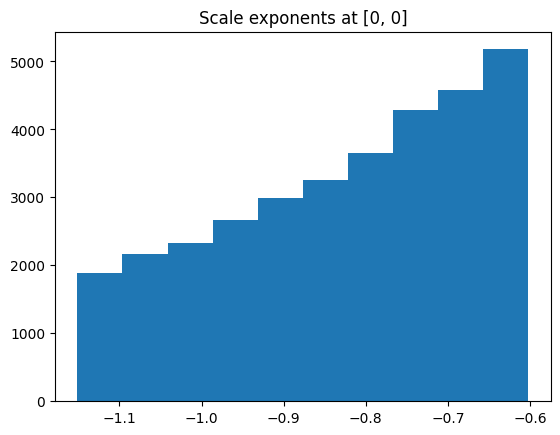

In [24]:
plt.hist(scale_exponents[:, 0, 0].clone().detach().cpu())
# plt.hist(scale[0, 0].detach().cpu())
_ = plt.title('Scale exponents at [0, 0]')

#### Pseudo algorithm

Below I tried to follow the steps from the paper (but some are skipped)

We can actually start training with lower resolution images (but then a new point cloud needs to be created)

In [25]:
width, height

(3072, 2304)

Filter splats that have means within a chosen tile - later we will probably need to come up with smarter way to assign gaussians to splats

In [26]:
coor = 1000
tile_size = 32
tile_left_lower, tile_upper_right = np.array([coor, coor]), np.array([coor + tile_size, coor + tile_size])

In [27]:
ids = (screen_coordinates[:, 0] > tile_left_lower[0]) & (screen_coordinates[:, 1] > tile_left_lower[1]) & (screen_coordinates[:, 0] < tile_upper_right[0]) & (screen_coordinates[:, 1] < tile_upper_right[1]) 
torch.sum(ids)

tensor(15, device='cuda:0')

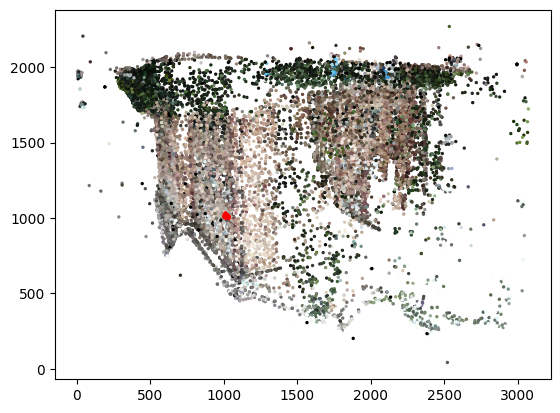

In [28]:
plt.scatter(screen_coordinates[~ids, 0].cpu().detach().numpy(), screen_coordinates[~ids, 1].cpu().detach().numpy(), s=2, c=c[~(ids.cpu().detach().numpy())].cpu().detach().numpy(), label='within a tile')
plt.scatter(screen_coordinates[ids, 0].cpu().detach().numpy(), screen_coordinates[ids, 1].cpu().detach().numpy(), s=5, c='red', label='outside')

In [29]:
splat_indexes = torch.where(ids == True)[0]
splat_indexes # indices of splats intersecting a chosen tile

tensor([  855,   873,   881,  1701,  4646,  5339,  6304,  6519,  6609, 14968,
        15128, 17410, 18007, 21377, 29822], device='cuda:0')

According to the original algorithm we also sort splats by their *z* coordinate  

In [30]:
z_sorted = screen_coordinates[splat_indexes, 2].sort()

In [31]:
z_indices = z_sorted.indices.type(torch.int)
print(z_indices)

tensor([ 6,  8,  5,  0,  4,  7,  1,  9,  2, 10, 13, 12, 14,  3, 11],
       device='cuda:0', dtype=torch.int32)


In [32]:
splat_z_indexes = splat_indexes[z_indices]
print(splat_z_indexes)

tensor([ 6304,  6609,  5339,   855,  4646,  6519,   873, 14968,   881, 15128,
        21377, 18007, 29822,  1701, 17410], device='cuda:0')


In [33]:
screen_coordinates[splat_z_indexes]

tensor([[1001.3662, 1018.9285,    6.3706],
        [1006.4677, 1011.2070,    6.3721],
        [1005.0593, 1022.6404,    6.3751],
        [1003.3591, 1014.9603,    6.3752],
        [1004.9011, 1007.0420,    6.3755],
        [1005.8243, 1024.5929,    6.3796],
        [1013.4578, 1020.7559,    6.3861],
        [1023.5831, 1017.4077,    6.3950],
        [1023.4136, 1017.8189,    6.3951],
        [1025.9486, 1005.9556,    6.3960],
        [1029.1620, 1004.7127,    6.3990],
        [1027.9734, 1014.9981,    6.3994],
        [1028.3237, 1003.6097,    6.4009],
        [1029.5161, 1014.3641,    6.4017],
        [1006.3964, 1030.1541,    6.4351]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [34]:
tile_pixels = np.array(list(itertools.product(range(coor, coor + tile_size), range(coor, coor + tile_size))))

In [35]:
tile_pixels # coordinates of pixels that lie within a chosen tile

array([[1000, 1000],
       [1000, 1001],
       [1000, 1002],
       ...,
       [1031, 1029],
       [1031, 1030],
       [1031, 1031]])

In [36]:
pixel = torch.tensor([coor + 16, coor + 16], device=device) # choose one pixel to be rendered

In [37]:
image_pt = torch.tensor(image / 255.0, device=device) # normalize color

In [38]:
# Camera coordinates are used to compute jacobian
# Formula inspired by the series of notebooks on medium 
class JacobianOps(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, cam_points, focal):
        ctx.save_for_backward(cam_points, focal)
        
        jacs = torch.zeros(len(cam_points), 3, 3, device=device, dtype=torch.float32)
        
        jacs[:, 0, 0] = focal / cam_points[:, 2]
        jacs[:, 1, 1] = focal / cam_points[:, 2]
        jacs[:, 2, 0] = -focal * cam_points[:, 0] / (cam_points[:, 2] ** 2)
        jacs[:, 2, 1] = -focal * cam_points[:, 1] / (cam_points[:, 2] ** 2)
        
        return jacs
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        points, focal = ctx.saved_tensors
        
        grad_points = torch.zeros_like(points)
        
        grad_points[:, 2] = grad_output[:, 0, 0] * (-focal / points[:, 2] ** 2) + grad_output[:, 1, 1] * (-focal / points[:, 2] ** 2)
        grad_points[:, 2] += grad_output[:, 2, 0] * (2 * focal * points[:, 0] / (points[:, 2] ** 3)) + grad_output[:, 2, 1] * (2 * focal * points[:, 1] / (points[:, 2] ** 3))
        grad_points[:, 0] = grad_output[:, 2, 0] * (-focal / (points[:, 2] ** 2))
        grad_points[:, 1] = grad_output[:, 2, 1] * (-focal / (points[:, 2] ** 2))
        
        return grad_points, None

In [39]:
def saturate(alphas):
    """
    Compute the number of Gaussians to consider until the saturation threshold (1.0) is reached
    :param alphas:
    :return: 
    """
    i = 0
    alpha_sum = 0
    while alpha_sum < 1.0 and i < len(alphas):
        alpha_sum += alphas[i]
        i += 1
    return i - 1

In [40]:
splat_rot = rot[splat_z_indexes]
splat_scale = torch.exp(scale_exponents[splat_z_indexes]).type(torch.float32)
splat_rs = torch.bmm(splat_rot, splat_scale)

splat_covs = torch.bmm(splat_rs, splat_rs.transpose(1, 2))

Js = JacobianOps.apply
jacobians = Js(camera_coordinates[splat_z_indexes], f_pt)

W_splats = torch.repeat_interleave(W[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)
M = torch.bmm(jacobians, W_splats)
proj_covs = torch.bmm(torch.bmm(M, splat_covs), M.transpose(1, 2))[:, :2, :2]

projs_inv = torch.linalg.inv(proj_covs)

pixel_pt = torch.repeat_interleave(pixel[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

diff = (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, :, torch.newaxis]
H = torch.bmm(diff.transpose(1, 2), projs_inv)
g_vals = torch.exp(-1 / 2 * torch.bmm(H, diff)).reshape(len(splat_indexes))

alphas = torch.sigmoid(alphas_exponents_pt[splat_z_indexes]).type(torch.float32)
saturation_depth = saturate(alphas)

weights = alphas[:saturation_depth] * g_vals[:saturation_depth]
color = weights.reshape(1, saturation_depth) @ colors[splat_z_indexes[:saturation_depth]]

loss = torch.sum(torch.abs(color - image_pt[pixel[0], pixel[1]]))

In [41]:
loss.backward()

In [42]:
points.grad[splat_z_indexes[:saturation_depth]]

tensor([[ 0.0009,  0.0001, -0.0005]], device='cuda:0')

In [43]:
rot.grad[splat_z_indexes[:saturation_depth]]

tensor([[[ 0.0005, -0.0005, -0.0010],
         [-0.0005,  0.0005,  0.0010],
         [-0.0010,  0.0010,  0.0020]]], device='cuda:0')

In [44]:
scale_exponents.grad[splat_z_indexes[:saturation_depth]]

tensor([[[0.0005, 0.0000, 0.0000],
         [0.0000, 0.0005, 0.0000],
         [0.0000, 0.0000, 0.0020]]], device='cuda:0', dtype=torch.float64)

#### Computations step-by-step

In [45]:
Js = JacobianOps.apply

In [46]:
camera_coordinates[splat_z_indexes]

tensor([[-0.6723, -0.2449,  3.0473,  1.0000],
        [-1.8243,  0.8520,  4.7638,  1.0000],
        [-1.1592, -0.2733,  3.7446,  1.0000],
        [-0.6376, -1.0639,  4.8485,  1.0000],
        [-1.3976,  0.8417,  3.8990,  1.0000],
        [-0.8424, -0.1989,  3.4392,  1.0000],
        [-0.6377, -0.1801,  2.9637,  1.0000],
        [-0.6446, -0.1282,  2.9689,  1.0000],
        [-1.5047, -0.5309,  4.4290,  1.0000],
        [-1.1669,  0.5175,  3.6211,  1.0000],
        [-0.5991, -0.1061,  2.8737,  1.0000],
        [-2.1045,  1.2596,  5.5795,  1.0000],
        [-2.2850,  0.6251,  6.1350,  1.0000],
        [-1.8920,  0.2504,  5.3649,  1.0000],
        [-1.9467,  0.8973,  5.3284,  1.0000]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [47]:
jacobians = Js(camera_coordinates[splat_z_indexes], f_pt)

In [48]:
camera_coordinates[0]

tensor([-1.2793,  0.5344,  3.7289,  1.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [49]:
jacobians[0]

tensor([[851.8366,   0.0000,   0.0000],
        [  0.0000, 851.8366,   0.0000],
        [187.9451,  68.4566,   0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [50]:
W_splats = torch.repeat_interleave(W[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

In [51]:
M = torch.bmm(jacobians, W_splats)

In [52]:
proj_covs = torch.bmm(torch.bmm(M, splat_covs), M.transpose(1, 2))[:, :2, :2]

In [53]:
proj_covs[0]

tensor([[ 1.3014e+05, -9.7656e-04],
        [-1.9531e-03,  1.3014e+05]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [54]:
proj_covs.shape

torch.Size([15, 2, 2])

In [55]:
projs_inv = torch.linalg.inv(proj_covs)

In [56]:
pixel_pt = torch.repeat_interleave(pixel[torch.newaxis, ...], repeats=len(splat_z_indexes), dim=0)

In [57]:
pixel

tensor([1016, 1016], device='cuda:0')

In [58]:
torch.exp(-1 / 2 * (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, torch.newaxis, :]).shape

torch.Size([15, 1, 2])

In [59]:
diff = (pixel_pt - screen_coordinates[splat_z_indexes, :2])[:, :, torch.newaxis]
H = torch.bmm(diff.transpose(1, 2), projs_inv)
g_vals = torch.exp(-1 / 2 * torch.bmm(H, diff)).reshape(len(splat_indexes))

In [60]:
g_vals

tensor([0.9991, 0.9993, 0.9985, 0.9977, 0.9992, 0.9995, 0.9998, 0.9997, 0.9997,
        0.9989, 0.9989, 0.9978, 0.9942, 0.9980, 0.9939], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [61]:
g_vals.shape

torch.Size([15])

In [62]:
alphas = torch.sigmoid(alphas_exponents_pt[splat_z_indexes]).type(torch.float32)

In [63]:
alphas.shape

torch.Size([15])

In [64]:
saturation_depth = saturate(alphas)

In [65]:
alphas[:saturation_depth]

tensor([0.9274], device='cuda:0', grad_fn=<SliceBackward0>)

In [66]:
weights = alphas[:saturation_depth] * g_vals[:saturation_depth]
weights

tensor([0.9266], device='cuda:0', grad_fn=<MulBackward0>)

In [67]:
colors[splat_z_indexes[:saturation_depth]].shape

torch.Size([1, 3])

In [68]:
color = weights.reshape(1, saturation_depth) @ colors[splat_z_indexes[:saturation_depth]]

In [69]:
color

tensor([[0.6468, 0.5778, 0.5632]], device='cuda:0', grad_fn=<MmBackward0>)

In [70]:
screen_coordinates[splat_z_indexes]

tensor([[1001.3662, 1018.9285,    6.3706],
        [1006.4677, 1011.2070,    6.3721],
        [1005.0593, 1022.6404,    6.3751],
        [1003.3591, 1014.9603,    6.3752],
        [1004.9011, 1007.0420,    6.3755],
        [1005.8243, 1024.5929,    6.3796],
        [1013.4578, 1020.7559,    6.3861],
        [1023.5831, 1017.4077,    6.3950],
        [1023.4136, 1017.8189,    6.3951],
        [1025.9486, 1005.9556,    6.3960],
        [1029.1620, 1004.7127,    6.3990],
        [1027.9734, 1014.9981,    6.3994],
        [1028.3237, 1003.6097,    6.4009],
        [1029.5161, 1014.3641,    6.4017],
        [1006.3964, 1030.1541,    6.4351]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [71]:
loss = torch.sum(torch.abs(color - image_pt[pixel[0], pixel[1]]))

In [72]:
loss

tensor(0.1368, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)